In [1]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel, StepModel #Modelli vari, l'ultimo è Fermi (o Bose)

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [2]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [3]:
#PATH_MARTI="../Dati/Run_chall_ChargeHistos_4_12_2024_10M.dat"
PATH_SAM="../Dati/Run_allch_TEST_7M_4_12_2024.dat"
edge_N, bin_N = load_histo(PATH_SAM)

channel = 15

if(channel == 12 or channel == 13 or channel == 1):
    exit()

channel_idx = [0, -1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1, -1, 11, 12]

    
edge_N = edge_N[channel_idx[channel]]
bin_N = bin_N[channel_idx[channel]]

rebin_fact = 1

#if channel == 5:
    #rebin_fact = 2
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

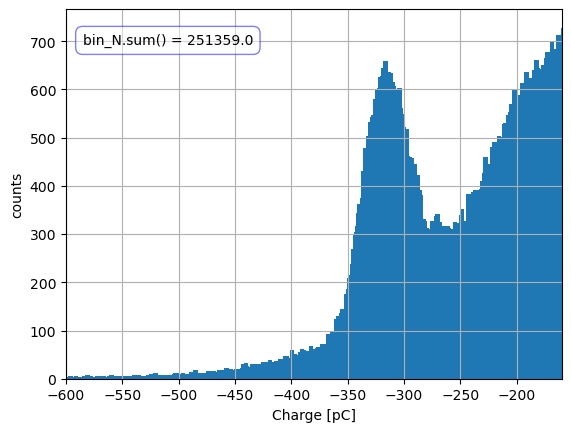

In [4]:
lim_list = [[-550, -165],  #ch0
            [-1, -1],      #ch1
            [-550, -175],  #ch2
            [-600, -145],  #ch3
            [-500, -165],  #ch4
            [-600, -175],  #ch5
            [-550, -155],  #ch6
            [-500, -180],  #ch7
            [-600, -170],  #ch8
            [-600, -160],  #ch9
            [-600, -130],  #ch10
            [-600, -165],  #ch11
            [-1, -1],      #ch12
            [-1, -1],      #ch13
            [-600, -140],  #ch14
            [-600, -160]   #ch15
            ]


lim_N = lim_list[channel]
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N, width = 4)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [5]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [6]:
bad_indices=np.where(err_N == 0)

In [7]:
#rattoppiamo i bin vuoti
for i in bad_indices:
    err_N[i] = 1
    bin_N[i] = 1

In [8]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide


params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   
params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))


model = exp1 + gauss1 + sigmoid1 + sigmoid2  

In [9]:
#CARICHIAMO I VALORI DI PARTENZA SU RUMORE
import pickle
with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

if (channel <14):
    noise_params = noise_params[channel]
elif(channel==14):
    noise_params = noise_params[12]
elif(channel==15):
    noise_params = noise_params[13]

noise_params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude  1.316e+04     -inf      inf      190     True     None     None
e1_decay        -83.88     -inf      inf   0.6513     True     None     None
ratio            23.95     -inf      inf   0.4402    False e1_amplitude / s1_amplitude     None
s1_amplitude     549.3        0      inf    9.749     True     None     None
s1_center       -400.3     -inf      inf   0.9277     True     None     None
s1_sigma         28.79        0      inf   0.6732     True     None     None


In [10]:
#IMPOSTIAMO I PARAMETRI

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
params.add("ratio", value = noise_params["ratio"].value)
params["e1_amplitude"].set(vary=True, expr = "ratio * s1_amplitude")



# Fit the model to the data
if channel ==0:
    params["g1_amplitude"].set(value = 70348, min=0 )   
    params["g1_center"].set(value = -309, min = -350 , max = -250)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

    params["e1_amplitude"].set(min=0)
    params["e1_decay"].set(value=-61)

    params["s1_amplitude"].set(value= 1534, min = 0)
    params["s1_center"].set(value=-270)
    params["s1_sigma"].set( value= 60)

    params["ratio"].set( value=4.89)

if channel ==2:

    params["g1_amplitude"].set(value = 425000 , min=0)   
    params["g1_center"].set(value = -325, min = -350 , max = -300)        
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].set(value = 5000, min=0)
    params["s2_center"].set(value = -230, min=-350,max=-150 )
    params["s2_sigma"].set(value = 5)

    params["e1_amplitude"].value = 54057.2496

    params["s1_amplitude"].set(min = 0)

if channel ==3:

    params["g1_amplitude"].set(value = 425000, min=0 )   
    params["g1_center"].set(value = -325, min = -350 , max = -300)        
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].set(value = 675, min=0)
    params["s2_center"].set(value = -230, min=-350,max=-150 )
    params["s2_sigma"].set(value = 5)

    params["e1_amplitude"].set( min=0)
    params["e1_decay"].set(value=-93)
    
    params["s1_amplitude"].set(value=927, min = 0)

    params["ratio"].set(value=7.71)

if channel == 4:
    
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -290, min = -340 , max = -260)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0, max=1200)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 23)
   
if channel == 5:
    params["g1_amplitude"].value=100000  
    params["g1_center"].set(value = -300, min = -330 , max = -250)        
    params["g1_sigma"].set(value = 14)
    params["e1_amplitude"].value=1000
    #params["e1_amplitude"].vary=True
    params["s2_amplitude"].set(value = 600, min=50, max=1000)
    #params["s2_center"].set(value = -180, min=-250,max=-150 )
    params["s2_center"].value= -180
    params["s2_sigma"].set(value = 9)

    params["s1_amplitude"].value=1000

if channel ==6:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -280, min = -320 , max = -250)        
    params["g1_sigma"].set(value = 14)
    params["e1_amplitude"].value = 1000
    params["s2_amplitude"].set(value = 100, min=0, max=1000)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)

    params["s1_amplitude"].set(value=1000)

if channel ==7:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -340, min = -380 , max = -300)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -220, min=-350,max=-150 )
    params["s2_sigma"].set(value = 9)


if channel == 8:
    params["e1_amplitude"].value=1000
    params["g1_sigma"].set(value = 15)
    params["g1_amplitude"].set(value=1000)
    params["g1_center"].set(value = -325, min=-350, max= -300)
    params["g1_sigma"].set(value = 15)

    params["s2_amplitude"].value=1000
    params["s2_center"].set(value = -230)
    params["s2_sigma"].set(value = 5)


if channel == 9:
    params["g1_center"].value=-286
    params["g1_center"].min=-300
    params["g1_center"].max = -250
    params["e1_amplitude"].value=6000
    params["e1_decay"].value=-79
    params["s1_amplitude"].value=102
    params["s1_center"].value=-405
    params["s1_sigma"].value=20.7
    params["g1_amplitude"].value=70550
    params["g1_sigma"].value=23.8
    params["s2_amplitude"].value=500
    params["s2_amplitude"].max=600
    params["s2_center"].value=-237
    params["s2_sigma"].value=26

    
    

if channel == 10:
    params["g1_center"].set(value=-380, min=-400, max = -350)
    params["g1_amplitude"].set(value=30000, min=100)
    params["s2_center"].set(value=-300, min=-300, max=-250)
    params["e1_amplitude"].value=2500
    params["s2_amplitude"].value=1000
    

if channel ==11:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -290, min = -300 , max = -280)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 600, min=0)
    params["s2_center"].set(value = -215, min=-250,max=-200 )
    params["s2_sigma"].set(value = 90)


if channel ==14:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -320, min = -330 , max = -310)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 500, min=0)
    params["s2_center"].set(value = -215, min=-250,max=-200 )
    params["s2_sigma"].set(value = 30, max=200)


if channel ==15:
    params["g1_amplitude"].set(value = 100000, min=0 )   
    params["g1_center"].set(value = -320, min = -330 , max = -310)        
    params["g1_sigma"].set(value = 14)

    params["s2_amplitude"].set(value = 500, min=0)
    params["s2_center"].set(value = -250, min=-240,max=-300 )
    params["s2_sigma"].set(value = 80, max=500)
    

params.update(params)
params.pretty_print()


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude  1.316e+04     -inf      inf     None    False ratio * s1_amplitude     None
e1_decay        -83.88     -inf      inf     None     True     None     None
g1_amplitude     1e+05        0      inf     None     True     None     None
g1_center         -320     -330     -310     None     True     None     None
g1_fwhm          32.97     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height         2850     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma            14        0      inf     None     True     None     None
ratio            23.95     -inf      inf     None     True     None     None
s1_amplitude     549.3     -inf      inf     None     True     None     None
s1_center       -400.3     -inf      inf     None     True     None     None
s1_sigma         28.79        0      inf     None     True     None     None
s2_amplitude    

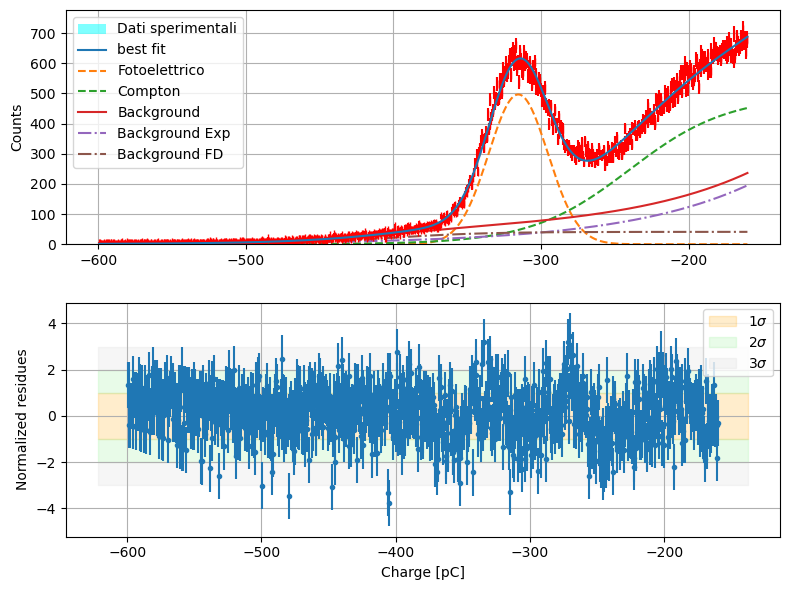

In [11]:
#FIT
params["s1_amplitude"].min = 0
params["s2_amplitude"].min = 0
params["g1_amplitude"].min = 0
params["e1_amplitude"].min = 0

result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(bin_N, range = lim_N, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centers_N, result.best_fit, label='best fit', zorder = 10)
ax1.plot(centers_N, comps['g1_'], label='Fotoelettrico', ls = "--")
ax1.plot(centers_N, comps['s2_'], label='Compton', ls = "--")

ax1.plot(centers_N, comps['e1_'] + comps['s1_'], label='Background')
ax1.plot(centers_N, comps['e1_'], label='Background Exp', ls = "-.")
ax1.plot(centers_N, comps['s1_'], label='Background FD', ls = "-.")

ax1.legend()
ax1.errorbar(centers_N, bin_N, err_N, color = "red", fmt='|')
ax1.grid()

residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(centers_N, norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

In [12]:
print(result.fit_report())

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(step, prefix='s1_', form='logistic')) + Model(step, prefix='s2_', form='logistic'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1826
    # data points      = 846
    # variables        = 11
    chi-square         = 976.519709
    reduced chi-square = 1.16948468
    Akaike info crit   = 143.380335
    Bayesian info crit = 195.526048
    R-squared          = 0.99997889
[[Variables]]
    e1_amplitude:  1232.43975 +/- 855.325210 (69.40%) == 'ratio * s1_amplitude'
    e1_decay:     -86.8780107 +/- 8.92163552 (10.27%) (init = -83.88444)
    s1_amplitude:  41.0443225 +/- 12.3470305 (30.08%) (init = 549.292)
    s1_center:    -403.833127 +/- 15.5000056 (3.84%) (init = -400.3329)
    s1_sigma:      32.9723845 +/- 5.34243047 (16.20%) (init = 28.79496)
    g1_amplitude:  24948.0253 +/- 543.494473 (2.18%) (init = 100000)
    g1_center:    -315.378386 +/- 0.21946156 (0.07%) (i

# Sistematiche

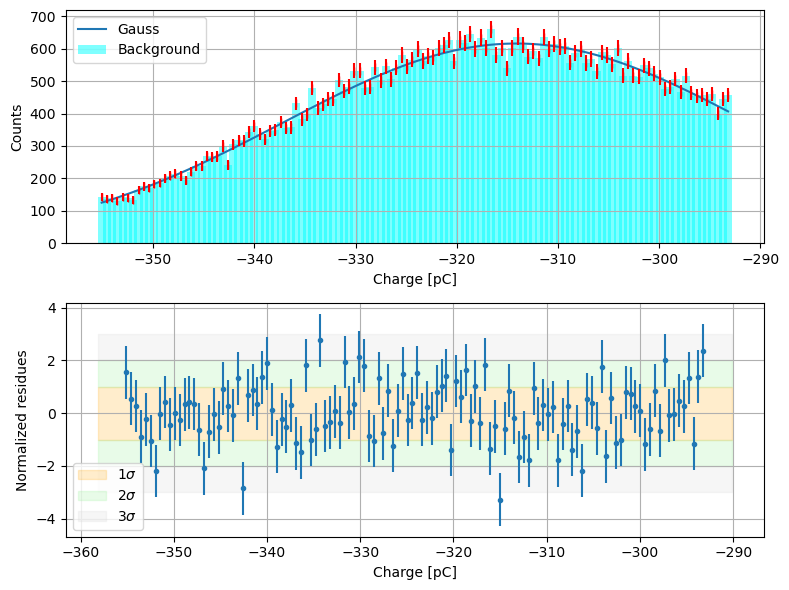

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 120
    # variables        = 3
    chi-square         = 150.284718
    reduced chi-square = 1.28448477
    Akaike info crit   = 33.0047845
    Bayesian info crit = 41.3672598
    R-squared          = 0.99994680
[[Variables]]
    g3_amplitude:  35429.2897 +/- 295.166232 (0.83%) (init = 33770.88)
    g3_center:    -314.119156 +/- 0.22687809 (0.07%) (init = -314.2663)
    g3_sigma:      22.9598887 +/- 0.23410852 (1.02%) (init = 21.32)
    g3_fwhm:       54.0664043 +/- 0.55128344 (1.02%) == '2.3548200*g3_sigma'
    g3_height:     615.605882 +/- 3.90459136 (0.63%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.7837
    C(g3_center, g3_sigma)     = +0.6813
    C(g3_amplitude, g3_center) = +0.6805


In [13]:
sist_lim_list = [[410, 500],  #ch0
                [-1, -1],  #ch1
                [340, 460],  #ch2
                [470, 595],  #ch3
                [345, 435],  #ch4
                [540, 630],  #ch5
                [460, 570],  #ch6
                [250, 350],  #ch7
                [490, 590],  #ch8
                [550, 725],  #ch9
                [370, 480],  #ch10
                [540, 620],  #ch11
                [-1, -1],  #ch12
                [-1, -1],  #ch13
                [460, 570],  #ch14
                [470, 590]   #ch15
                ]


sist_lims = sist_lim_list[channel]
sist_bin = bin_N[sist_lims[0]:sist_lims[1]]
sist_cntr = centers_N[sist_lims[0]:sist_lims[1]]
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())